In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import seaflowpy as sfp
import mpld3 
import scipy.stats as ss

from matplotlib import path
import matplotlib.patches as patches

import glob
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def get_filter_line(inst, bead_coords):
    # this is using fsc and D2
    # slopes to use for calibration
    calib = pd.DataFrame()

    calib['inst'] = [740, 740, 751, 751, 989, 989]
    calib['regime'] = ['coastal', 'oligo', 'coastal', 'oligo', 'coastal', 'oligo']
    calib['slope_S'] = [0.87, 0.89, 0.63, 0.62, 0.87, 0.91]
    #calib['slope_S'] = [0.62, 0.89, 0.63, 0.62, 0.87, 0.91]

    calib['slope_B'] = [2.17, 1.95, 2.3, 2.59, 1.64, 1.75]
    
    m_S = np.min(calib.slope_S[(calib['inst']==inst)])
    m_B = np.min(calib.slope_B[(calib['inst']==inst)])

    bead_x = bead_coords[0]
    bead_y = bead_coords[1]#+5000
    
    max_x = 64000.
    
    intercept_S = bead_y - m_S*bead_x
    c_B = bead_y - m_B*bead_x
    intercept_B = m_B*max_x + c_B
    
    # create an array with the coordinates for each point in the polygon
    filter_polygon = [(0, 0), (0, intercept_S), (bead_x, bead_y), (max_x,intercept_B), (max_x, 0), (0,0)]

    return filter_polygon

def filter_evt(filter_polygon, data):
    # http://stackoverflow.com/questions/31542843/inpolygon-for-python-examples-of-matplotlib-path-path-contains-points-method
    # define the path using the points from get_filter_line
    
    p = path.Path(filter_polygon)
    tmp = p.contains_points(data[['fsc_small', 'D2']])
    opp = data.loc[tmp, :]
    
    return opp

def align_evt(data, width, origin):
    # Filter aligned particles (D1 = D2), with correction for D1 D2
    # sensitivity difference
    alignedD1 = (data.df["D1"] + origin) < (data.df["D2"] + (width * 10**4))
    alignedD2 = data.df["D2"] < (data.df["D1"] + origin + (width * 10**4))
    aligned = data.df[alignedD1 & alignedD2]
    
    return aligned
    


In [3]:
# bead coordinates
bead_coords = pd.DataFrame()

bead_coords['inst'] = [740, 740, 751, 751, 989, 989]
bead_coords['regime'] = ['oligo', 'coastal', 'oligo', 'coastal', 'oligo', 'coastal']
bead_coords['fsc_small'] = [49000, 38100, 53500, 41400, 50800, 40700]
bead_coords['D2'] = [24400, 23200, 23500, 22400, 20500, 19000]
#bead_coords['D2'] = [25400, 23200, 23500, 22400, 20500, 19000]

# load in the data, one file at a time per instrument
# set the wdirectory where the data is stored

datadir = "/Volumes/ceg/Sophie/bead_calibration/"

# select instrument
inst = 989
instdir = "%3d_caldata" % inst

indir = "%s%s" % (datadir, instdir)
regime = 'coastal' # or oligo
regime = 'oligo'

files = glob.glob('%s/*%s*.evt' % (indir, regime))

# get the coordinates for the filter polygon for this instrument and bead combination

bead_xy = np.empty(2)

bead_xy[0] = bead_coords.fsc_small[(bead_coords['inst']==inst) & (bead_coords['regime']==regime)]
bead_xy[1] = bead_coords.D2[(bead_coords['inst']==inst) & (bead_coords['regime']==regime)]

filter_polygon = get_filter_line(inst, bead_xy)

print filter_polygon

#bead_data.df['fsc_small'], bead_data.df['D2']

[(0, 0), (0, -23696.0), (50800.0, 20500.0), (64000.0, 42148.0), (64000.0, 0), (0, 0)]


/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_0.3um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_0.75um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-03-01_989_oligo_noise.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_1.83um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_3.1um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_1.0um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_0.5um.evt


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


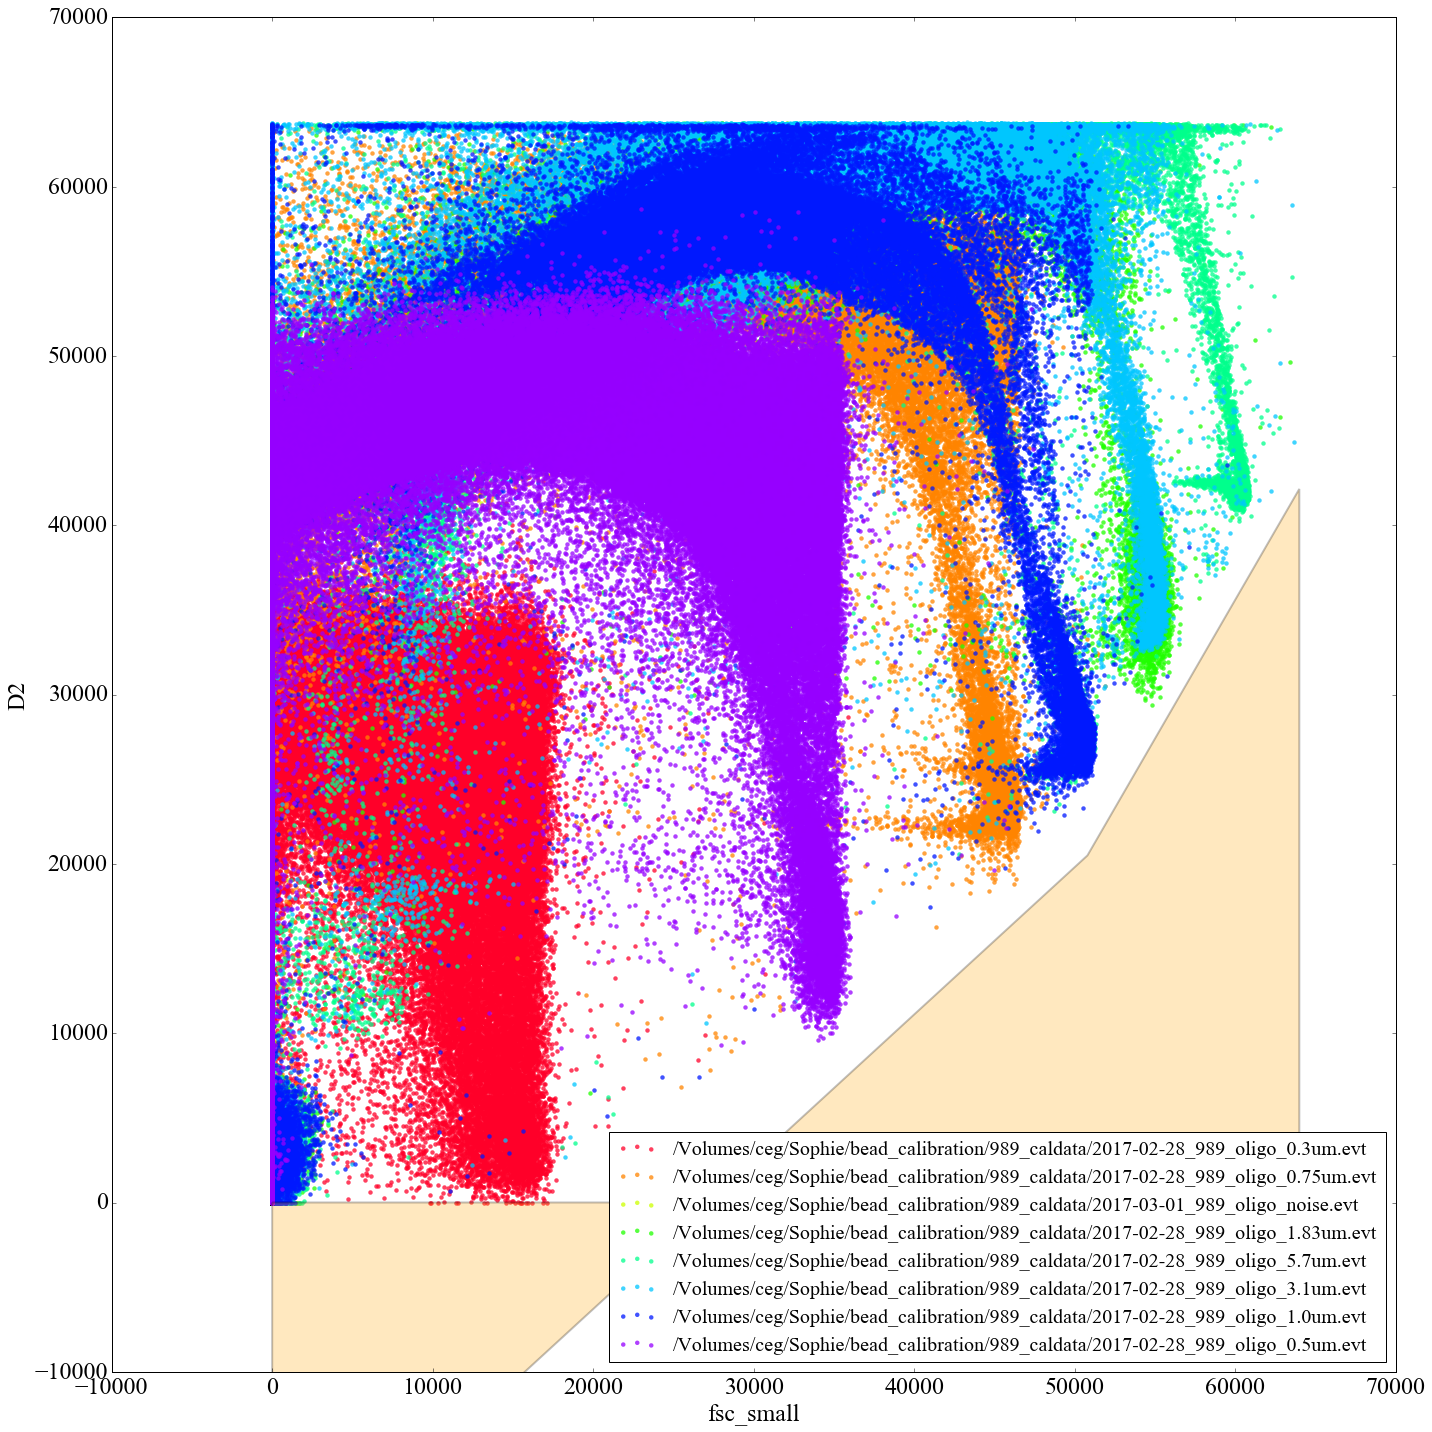

In [4]:
fig1 = plt.figure(figsize=(20,20), dpi = 600)

num_cols = len(files)

cm = plt.get_cmap('gist_rainbow')
#for i in range(num_cols):
#    color = cm(1.*i/num_cols)

ax = fig1.add_subplot(111)

cc = 0
for f in files:
    print f
    data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1","D2",'pe'])
    bead_data = align_evt(data, 0.5, 0.)
    plt.scatter(bead_data['fsc_small'], bead_data['D2'], marker ='o', lw = 0, c = cm(1.*cc/num_cols), label = f, alpha = 0.75)
    cc += 1

plt.xlabel('fsc_small', fontsize = 24)
plt.ylabel('D2', fontsize = 24)
plt.legend(loc = 'lower right', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=24)

p = path.Path(filter_polygon)

patch = patches.PathPatch(p, facecolor='orange', lw=2, alpha = 0.25)
ax.add_patch(patch)

plt.axis([-10000, 70000, -10000, 70000])
plt.show()


In [5]:
bead_data = []

columns = ['inst', 'file', 'evt', 'opp']
opp = pd.DataFrame(columns=columns)

datadir = "/Volumes/ceg/Sophie/bead_calibration/"
regime = ['coastal', 'oligo']
inst = [740, 751, 989]


for i in inst:

    instdir = "%3d_caldata" % i

    indir = "%s%s" % (datadir, instdir)
    for r in regime:
        bead_xy = np.empty(2)

        bead_xy[0] = bead_coords.fsc_small[(bead_coords['inst']==i) & (bead_coords['regime']==r)]
        bead_xy[1] = bead_coords.D2[(bead_coords['inst']==i) & (bead_coords['regime']==r)]
        files = glob.glob('%s/*%s*.evt' % (indir, r))
        for f in files:
            #print f
            data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1", "D2", "pe"])
            bead_data = align_evt(data, 0.25, 0.)
            fstripped = f.lstrip(indir)[:-4]
            b = fstripped.rstrip('um').split('_')[3]
            filter_polygon = get_filter_line(i, bead_xy)
            
            print fstripped#, 'opp/evt = ', len(tmp[0])/np.float(len(bead_data.df))
            
            if b != 'noise':
                tmp = filter_evt(filter_polygon, bead_data)
                #fig1 = plt.figure(figsize=(10,10), dpi = 600)
                #ax = fig1.add_subplot(111)
                
                #plt.scatter(bead_data['fsc_small'], bead_data['D2'], marker ='o',c='r', lw = 0, label = f, alpha = 0.75)
                #plt.scatter(tmp['fsc_small'], tmp['D2'], marker ='o', lw = 0, label = f, alpha = 0.75)
                
                #p = path.Path(filter_polygon)

                #patch = patches.PathPatch(p, facecolor='orange', lw=2, alpha = 0.25)
                #ax.add_patch(patch)

                #plt.axis([-10000, 70000, -10000, 70000])
                #plt.show()
                opp = opp.append({'inst': int(i), 'regime': r, 'bead': float(b), 'file': fstripped, 'evt' : np.float(len(data.df)), 'opp' : np.float(len(tmp))}, ignore_index=True)

    


2017-02-22_740_coastal_5.7um
2017-02-22_740_coastal_1.8um
2017-02-21_740_coastal_1um
2017-02-22_740_coastal_0.75um
2017-02-22_740_coastal_0.5um
2017-02-22_740_coastal_3.1um
2017-02-21_740_oligo_1um
2017-02-21_740_oligo_3.1um
2017-02-21_740_oligo_5.7um
2017-02-22_740_oligo_1.83um
2017-02-21_740_oligo_0.5um
2017-02-21_740_oligo_0.75um
2017-02-22_740_oligo_noise
2017-02-21_740_oligo_0.3um
2017-02-17_751_coastal_5.7um
2017-02-17_751_coastal_3.1um
2017-02-17_751_coastal_1um
2017-02-17_751_coastal_0.75um
2017-02-18_751_coastal_0.31um
2017-02-17_751_coastal_0.5um
2017-02-17_751_oligo_0.75um
2017-02-17_751_oligo_5.7um
2017-02-17_751_oligo_1.83um
2017-02-17_751_oligo_0.3um
2017-02-17_751_oligo_noise
2017-02-17_751_oligo_3.1um
2017-02-17_751_oligo_0.5um
2017-02-17_751_oligo_1um
2017-02-17_751_oligo_0.18um
2017-02-28_989_coastal_3.1um
2017-03-01_989_coastal_1.83um
2017-03-01_989_coastal_0.5um
2017-02-28_989_coastal_1.0um
2017-03-01_989_coastal_noise
2017-02-28_989_coastal_5.7um
2017-03-01_989_coa

In [6]:
opp['oppevt'] = opp['opp']/opp['evt']

# get the flow rates for the concentration calculation
flow_file = '%sbeadcalruntimes_flowrates.csv' % datadir
flow = pd.read_csv(flow_file,sep = ',' )
flow.rename(columns={'FILE NAME':'file'}, inplace = True)

print opp.columns

opp = opp.sort('file', ascending = 1)
flow = flow.sort('file', ascending = 1)

opp = pd.merge(opp, flow, on='file')
opp['concentration (bead/ul)'] = (opp['opp']/2)/(opp['volume (ml)']*opp['oppevt']*1000)

opp["inst"] = opp["inst"].astype(int)


print flao

Index([u'inst', u'file', u'evt', u'opp', u'bead', u'regime', u'oppevt'], dtype='object')
                             file  TIME (SEC.)  volume (ml)
33     2017-02-17_751_coastal_0.5          123    33.805867
30    2017-02-17_751_coastal_0.75          180    49.472000
31     2017-02-17_751_coastal_1um          140    38.478222
34   2017-02-17_751_coastal_3.1um          106    29.133511
32   2017-02-17_751_coastal_5.7um          179    49.197156
37    2017-02-17_751_oligo_0.18um           93    25.560533
35     2017-02-17_751_oligo_0.3um           67    18.414578
36     2017-02-17_751_oligo_0.5um           99    27.209600
38    2017-02-17_751_oligo_0.75um          100    27.484444
39    2017-02-17_751_oligo_1.83um           57    15.666133
40       2017-02-17_751_oligo_1um          102    28.034133
41     2017-02-17_751_oligo_3.1um          123    33.805867
42     2017-02-17_751_oligo_5.7um          121    33.256178
43     2017-02-17_751_oligo_noise          180    49.472000
44  2017-02

/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [15]:
# load in the calibration data from the influx

calib = pd.read_csv('/Volumes/ceg/Sophie/bead_calibration/beadcal_data.csv', sep = ',')
calib.rename(columns={'Bead Size (um)':'bead', 'beads/ ul': 'influx concentration (bead/ul)'}, inplace =True)
print calib.columns

# join to the opp dataframe
seaf_infl = pd.merge(opp, calib, on=['inst', 'regime', 'bead'])

dr = [0.136, 0.143, 0.149]
fvar = 'concentration (bead/ul)'

for i in range(3):
    seaf_infl.loc[seaf_infl['inst']==inst[i], fvar] = seaf_infl.loc[seaf_infl['inst']==inst[i], fvar]/dr[i]
    

Index([u'inst', u'bead', u'regime', u'Bead Events', u'Volume (ul)',
       u'influx concentration (bead/ul)', u'File Name', u'Unnamed: 7'],
      dtype='object')


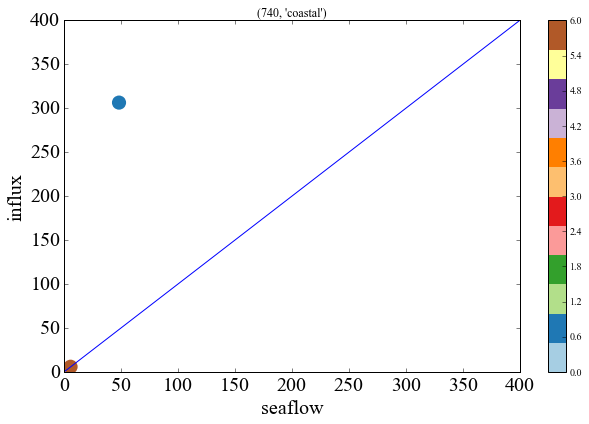

statistics, slope =  nan , r =  nan , p-value < 0.05  False


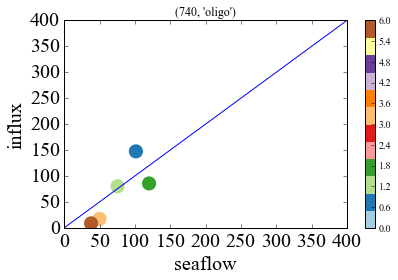

statistics, slope =  3.46930883317 , r =  0.538568960171 , p-value < 0.05  False


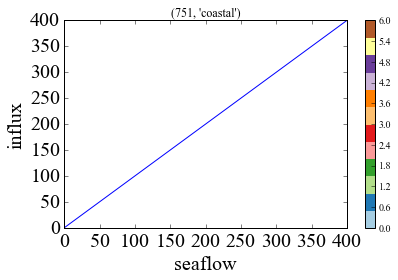

statistics, slope =  nan , r =  nan , p-value < 0.05  False


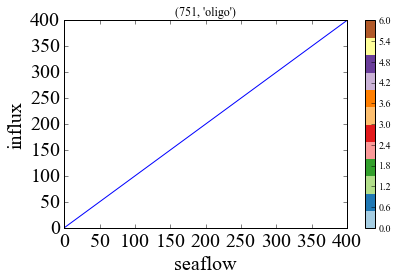

statistics, slope =  nan , r =  nan , p-value < 0.05  False


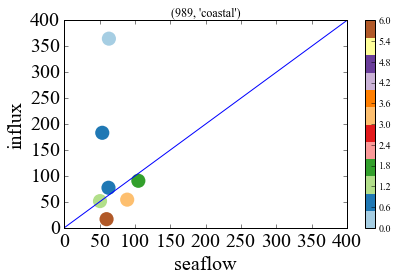

statistics, slope =  -0.944057870984 , r =  -0.157857617717 , p-value < 0.05  False


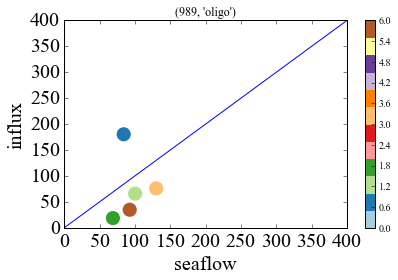

statistics, slope =  6.04153752169 , r =  0.889109810815 , p-value < 0.05  True


In [16]:
fig1 = plt.figure(figsize=(9, 6), dpi = 600)

palette = plt.cm.get_cmap('Paired', 12)

n=0

for i in inst:
    for r in regime:
        subset = seaf_infl[(seaf_infl['inst']==i) & (seaf_infl['regime']==r)]
        
        plt.scatter(subset['concentration (bead/ul)'], subset['influx concentration (bead/ul)'], c = (subset['bead'].values), lw = 0, s = 200, vmin = 0,vmax = 6, cmap=palette)
        plt.plot([0,600], [0, 600])
        plt.xlabel('seaflow', fontsize = 20)
        plt.ylabel('influx', fontsize = 20)
#plt.title('%s - %s' % (i, r))
        plt.colorbar()
        plt.axis([0, 400, 0, 400])
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.title((i, r))

        plt.show()
    
        m,c, rR, p, std_err = ss.linregress(subset['concentration (bead/ul)'], subset['influx concentration (bead/ul)'])
        print 'statistics, slope = ', m, ', r = ', rR, ', p-value < 0.05 ', p<0.05
n +=1

